# Diccionario de atributos

anime_id - myanimelist.net's unique id identifying an anime.

name - full name of anime.

genre - comma separated list of genres for this anime.

type - movie, TV, OVA, etc.

episodes - how many episodes in this show. (1 if movie).

rating - average rating out of 10 for this anime.

members - number of community members that are in this anime's "group".

user_id - non identifiable randomly generated user id.

anime_id - the anime that this user has rated.

rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

# Importación de Librerias


In [1]:
#Importamos librerias
import numpy as np
import pandas as pd
import seaborn as sns
import dask as dd #por si las cosas se ponen feas

# Importación de Datos

In [53]:
#importamos la data de ratings
ratings = pd.read_csv('rating.csv')
ratings.head(2)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1


count    7.813737e+06
mean     6.144030e+00
std      3.727800e+00
min     -1.000000e+00
25%      6.000000e+00
50%      7.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

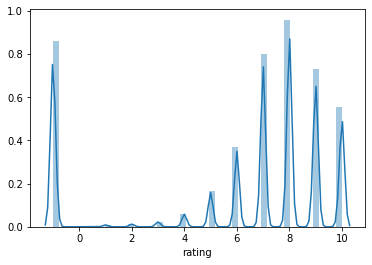

In [54]:
#información basica sobre sobre ratings
sns.distplot(ratings.rating)
ratings.rating.describe()

In [55]:
#importamos la data de anime
anime = pd.read_csv('anime.csv')
anime.head(2)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665


In [5]:
#Para evitar confusiones con los nombres
anime['anime_rating']=anime.rating.copy()
anime.drop('rating',axis=1,inplace=True)
anime.columns

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'members',
       'anime_rating'],
      dtype='object')

# Variables Categoricas
Las variables categoricas, deben ser codificadas de tal manera que sean representadas numericamente, y que tal representación tenga un peso matematicamente. De lo contrario ciertos modelos podrían malinterpretar los datos, por ejemplo:

Accion =1

Comedia =2

Artes Marciales =3

implica cosas como:
$$d(Accion,Comedia)<d(Accion,Artes Marciales)  $$
$$ Acción+Comedia=Artes Marciales$$


Si bien hay modelos especificos qué tratan con variables categoricas, una solución más sencilla y menos limitante es convertirlas a variables dummies, de forma que Acción y Comedia sean tratados como atributos independientes.

In [56]:
#Pasamos los generos a dummies
anime=pd.concat([anime.drop('genre',axis=1),anime.genre.str.get_dummies(sep=',')],axis=1)

In [57]:
#Pasamos el tipo a dummies
anime=pd.concat([anime.drop('type',axis=1),anime.type.str.get_dummies(sep=',')],axis=1)

# Mean Rating Per User
Siguiendo la idea del usuario Lastnight* de Kaggle, es conveniente definir el rating promedio por usuario (MRPU) debido a los diferentes criterios de evaluación, de este modo evitaremos que en situaciones en donde le recomendemos a una persona exigente que le puso un 10 a un anime los mismos animes que ha visto alguien que puntua todos con 10.

Si bien la idea de Lastnight es excelente hay que adecuar su implementación para nuestros fines, que sería estandarízar las evaluaciones de los usuarios para desarrollar un algoritmo de recomendación más preciso.
Para esto necesitamos una metrica que tome de punto de origen el MRPU, por ejemplo la unidad tipificada:
$$ Z=\frac{x-\overline{x}}{\sigma} $$
Donde x es el valor actual, $\overline{x}$ la media (MPRU en nuestro caso), y $\sigma$ la desviación standar.

Además, para esto no debemos considerar el valor -1 (No puntuados), porque ensuciaría nuestros resultados.


*https://www.kaggle.com/tanetboss/user-clustering-for-anime-recommendation


In [113]:
#Numero de usuarios unicos 
ratings.user_id.nunique()

73515

In [118]:
#Numero de usuarios que no han puntuado nada
len(ratings[ratings['rating']<0].groupby(['user_id'], as_index=True).nunique())

37128

In [117]:
#Numero de usuarios que han puntuado algo
len(ratings[ratings['rating']>0].groupby(['user_id'], as_index=True).nunique())

69600

In [108]:
#Numero de rating puntuados
len(ratings[ratings['rating']>0])

6337241

In [86]:
#creamos un dataframe auxiliar que contenga los usuarios que han puntuado algo (Solo por comodidad)
puntuados=ratings[ratings['rating']>0][['user_id','rating']].reset_index(drop=True)

In [111]:
puntuados.groupby(['user_id'],as_index=True).rating.apply(lambda x : (x-x.mean()/(x.std()+20)))

0          9.500000
1          9.500000
2          9.500000
3          9.500000
4               NaN
             ...   
6337236    6.595626
6337237    8.595626
6337238    9.595626
6337239    8.550000
6337240    8.550000
Name: rating, Length: 6337241, dtype: float64

In [71]:
Z = ratings.groupby(['user_id'], as_index=True)['rating'].apply(lambda x : (x-x.mean()))
#MRPU['mean_rating'] = MRPU['rating']

#MRPU.drop(['anime_id','rating'],axis=1, inplace=True)

In [66]:
Z

0         -0.287582
1         -0.287582
2         -0.287582
3         -0.287582
4         -0.287582
             ...   
7813732   -0.719388
7813733    1.280612
7813734    2.280612
7813735    0.000000
7813736    0.000000
Name: rating, Length: 7813737, dtype: float64

# Union de los Datasets

In [37]:
#Juntamos los datasets para tener la informacipon completa
data=pd.merge(rating,anime,on='anime_id',how='left',indicator=True)
data.head()

MemoryError: 

In [ ]:
#Revisemos si alguno no nos cruzó
len(rating)-len(data[data._merge=='both'])

In [ ]:
#Los siguientes anime_id no están presentes en la lista de anime
rating.anime_id[data['_merge']=='left_only'].unique()

In [ ]:
#dejamos fuera aquellas filas cuyo anime_id no se corresponde entre los dos sets.
data=data[data._merge=='both']

In [36]:
#por si alguien se pregunta cual es el anime peor evaluado
data[data['anime_rating']==data['anime_rating'].min()]

,user_id,anime_id,rating,name,episodes,members,anime_rating,Adventure,Cars,Comedy,...,Thriller,Vampire,Yaoi,Movie,Music,ONA,OVA,Special,TV,_merge
5106536,48766,34476,-1,Platonic Chain: Ansatsu Jikkouchuu,1,51.0,1.67,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,both


In [34]:
#por si alguien se pregunta cual es el anime mejor evaluado
data[data['anime_rating']==data['anime_rating'].max()]

,user_id,anime_id,rating,name,episodes,members,anime_rating,Adventure,Cars,Comedy,...,Thriller,Vampire,Yaoi,Movie,Music,ONA,OVA,Special,TV,_merge
5105060,48766,23005,-1,Mogura no Motoro,1,62.0,9.5,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,both
